In [314]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

### Parameters

In [315]:
iteration = 2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 50,
    'knn_k':30
}
patient_filtering_dict = {

}

# Subset 1

### Load Gram matrix and clinical data

In [316]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
Age = [clinical.loc[clinical['patient_id'] == patient_id, 'Age at Diagnosis'].values[0] for patient_id in Patient_IDs]
Grade = [clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs]
ER_status = [clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs]
PR_status = [clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs]
HER2_status = [clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs]
Clinical_subtypes = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs])
print(np.unique(Clinical_subtypes))


Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
Histograms = Histograms/np.sum(Histograms, axis = 1, keepdims = True)
Age = np.array(Age)[Patient_Inclusion_mask]
Grade = np.array(Grade)[Patient_Inclusion_mask]
ER_status = np.array(ER_status)[Patient_Inclusion_mask]
PR_status = np.array(PR_status)[Patient_Inclusion_mask]
HER2_status = np.array(HER2_status)[Patient_Inclusion_mask]
Clinical_subtypes = Clinical_subtypes[Patient_Inclusion_mask]
print(np.unique(Clinical_subtypes))
print("{} patients are included".format(len(Patient_IDs)))
print(np.percentile(Gram_matrix, 50), np.percentile(Gram_matrix, 75), np.percentile(Gram_matrix, 90), np.percentile(Gram_matrix, 95), np.percentile(Gram_matrix, 99))

['HR+/HER2+' 'HR+/HER2-' 'HR-/HER2+' 'TNBC' 'nan']
['HR+/HER2+' 'HR+/HER2-' 'HR-/HER2+' 'TNBC' 'nan']
379 patients are included
0.10253208654279589 0.2628088408628738 0.4797028513019933 0.6167046777657275 0.8942353042265045


### Community detection

In [317]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

### Survival analysis for subgroups

In [318]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relapse-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

379 patients are included
S1 (N = 26):
Survival: hr = 2.428013562030345, p = 0.0009529780614233097
	Significant
S2 (N = 48):
Survival: hr = 1.6715184635587368, p = 0.02843447397812587
S3 (N = 23):
Survival: hr = 1.1993259620126575, p = 0.6188721644067485
S4 (N = 73):
Survival: hr = 1.1496241238841327, p = 0.5148989278165488
S5 (N = 61):
Survival: hr = 0.9672335783354061, p = 0.8872245985054152
S6 (N = 51):
Survival: hr = 0.6150989479810047, p = 0.12382629829932304
S7 (N = 97):
Survival: hr = 0.514502885809581, p = 0.005382388188832714
	Significant


### Find Over-presented Patterns

In [319]:
def hodges_lehmann_estimator(x, y):
    """
    Compute the Hodges-Lehmann estimator for the median difference between two samples.

    Parameters:
    - x: numpy array, first sample
    - y: numpy array, second sample

    Returns:
    - Hodges-Lehmann estimator
    """
    n = len(x)
    m = len(y)
    hl_estimates = []

    for i in range(n):
        for j in range(m):
            hl_estimates.append((x[i] - y[j]))

    return np.median(hl_estimates)


Overpresented_patterns = {}
import scipy.stats as stats

for subgroup_id in [1, 2, 3, 4, 5, 6, 7]:
    Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
    Histogram_other_group = Histograms_[Subgroup_ids_ != subgroup_id]
    Hodges_lehmann = []
    P_value = []
    for pattern_id in range(Histograms_.shape[1]):
        histogram_intra_group = Histogram_intra_group[:, pattern_id]
        histogram_other_group = Histogram_other_group[:, pattern_id]
        test_result = stats.mannwhitneyu(
            histogram_intra_group, histogram_other_group, alternative="greater"
        )
        P_value.append(test_result.pvalue)
        hodges_lehmann = hodges_lehmann_estimator(
            histogram_intra_group, histogram_other_group
        )
        Hodges_lehmann.append(hodges_lehmann)
    Hodges_lehmann = np.array(Hodges_lehmann)
    P_value = np.array(P_value)

    # Index = np.argsort(Hodges_lehmann)
    Index = np.arange(len(Hodges_lehmann))

    # ax.plot(np.sort(Hodges_lehmann), color = 'grey', linestyle = '--', markersize = 3)
    DF = pd.DataFrame(
        {
            "Hodges-Lehmann": Hodges_lehmann[Index],
            "P_value": P_value[Index] < 0.05,
            "Overpresented": Hodges_lehmann[Index] > 0.5 * np.max(Hodges_lehmann),
        }
    )
    Pattern_ids = np.where(
        (P_value < 0.05) & (Hodges_lehmann > 0.5 * np.max(Hodges_lehmann))
    )[0]
    Overpresented_patterns[subgroup_id] = Pattern_ids

print(Overpresented_patterns)

{1: array([16]), 2: array([10]), 3: array([4]), 4: array([0]), 5: array([14]), 6: array([2]), 7: array([12, 21, 26])}


# Fit

320
age + grade + clinical_subtype + S1 + S2 + S3 + S4 + S5 + S6 + S7


<lifelines.CoxPHFitter: fitted with 320 total observations, 209 right-censored observations>
             duration col = 'length'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 320
number of events observed = 111
   partial log-likelihood = -561.46
         time fit was run = 2024-01-02 21:07:43 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
S1                              0.12       1.13       0.10            -0.07             0.31                 0.93                 1.36
S2                              0.15       1.16       0.09            -0.03             0.33                 0.97                 1.40
S3                              0.15       1.16       0.10            -0.04             0.35                 0.96                 1.42
S4                             -0.08       0.92       0.10            -0.29             0.13                 0.75                 1.13
S5                             -0.14       0.87       0.12            -0.38             0.10                 0.68                 1.10
S6                             -0.02       0.98       0.12            -0.25             0.22                 0.78                 1.24
S7                              0.03       1.03       0.13            -0.23             0.29                 0.80                 1.34
age                             0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
clinical_subtype[T.HR+/HER2-]  -0.31       0.73       0.45            -1.20             0.58                 0.30                 1.78
clinical_subtype[T.HR-/HER2+]   0.83       2.29       0.48            -0.10             1.76                 0.90                 5.83
clinical_subtype[T.TNBC]        0.16       1.17       0.48            -0.77             1.09                 0.46                 2.98
grade                           0.79       2.20       0.19             0.42             1.16                 1.53                 3.18

                                cmp to     z      p   -log2(p)
covariate                                                     
S1                                0.00  1.24   0.21       2.22
S2                                0.00  1.60   0.11       3.18
S3                                0.00  1.53   0.13       2.98
S4                                0.00 -0.76   0.45       1.16
S5                                0.00 -1.17   0.24       2.04
S6                                0.00 -0.13   0.90       0.16
S7                                0.00  0.25   0.80       0.31
age                               0.00  3.29 <0.005       9.94
clinical_subtype[T.HR+/HER2-]     0.00 -0.69   0.49       1.03
clinical_subtype[T.HR-/HER2+]     0.00  1.74   0.08       3.62
clinical_subtype[T.TNBC]          0.00  0.34   0.74       0.44
grade                             0.00  4.21 <0.005      15.26
---
Concordance = 0.73
Partial AIC = 1146.91
log-likelihood ratio test = 57.18 on 12 df
-log2(p) of ll-ratio test = 23.70

<AxesSubplot: xlabel='log(HR) (95% CI)'>

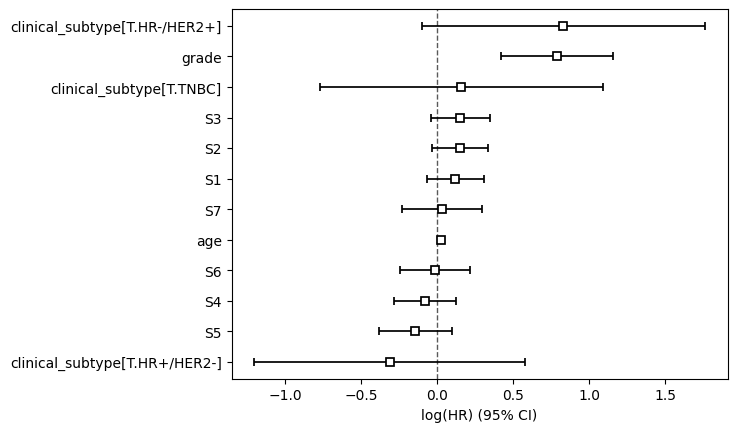

In [331]:
DF = pd.DataFrame(
    {
        "length": Length,
        "status": Status,
        "age": Age,
        "grade": Grade,
        "clinical_subtype": Clinical_subtypes,
    }
)

for subgroup_id, Candidates in Overpresented_patterns.items():
    histogram = np.sum(Histograms_[:, Candidates], axis=1)
    DF["S{}".format(subgroup_id)] = (histogram - np.mean(histogram)) / np.std(histogram)

DF = DF.dropna()
print(len(DF))

DF["clinical_subtype"] = pd.Categorical(DF["clinical_subtype"])

formula = "age + grade + clinical_subtype"+" + " + " + ".join(DF.columns[5:])
print(formula)

cph = CoxPHFitter(penalizer=0.01)

cph.fit(DF, duration_col="length", event_col="status", formula=formula)
cph.print_summary()
cph.plot()

# Cohort 2

In [332]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]


Age_cohort2 = [clinical.loc[clinical['patient_id'] == patient_id, 'Age at Diagnosis'].values[0] for patient_id in Patient_IDs_cohort2]
Grade_cohort2 = [clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs_cohort2]
Clinical_subtype_cohort2 = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_cohort2]
print(np.unique(Clinical_subtype_cohort2))


Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

if survival_type == 'Overall':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs_cohort2]  
elif survival_type == 'Relpase-free':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs_cohort2] 
elif survival_type == 'Disease-specific':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs_cohort2]
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Histograms_cohort2_ = Histograms_cohort2_/np.sum(Histograms_cohort2_, axis=1, keepdims=True)
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]
Clinical_subtype_cohort2_ = np.array(Clinical_subtype_cohort2)[DF_cohort2.index.values]
Age_cohort2_ = np.array(Age_cohort2)[DF_cohort2.index.values]
Grade_cohort2_ = np.array(Grade_cohort2)[DF_cohort2.index.values]


['HR+/HER2+' 'HR+/HER2-' 'HR-/HER2+' 'TNBC' 'nan']
200 patients are included


In [333]:

DF = pd.DataFrame({
    'length': Length_cohort2_,
    'status': Status_cohort2_,
    "age": Age_cohort2_,
    "grade": Grade_cohort2_,
    "clinical_subtype": Clinical_subtype_cohort2_
})


i = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    histogram = np.sum(Histograms_cohort2_[:, Candidates], axis = 1)
    DF["S{}".format(subgroup_id)] = (histogram - np.mean(histogram))/np.std(histogram)
formula = formula + ' + ' + ' + '.join(DF.columns[2:])

DF = DF.dropna()
DF['clinical_subtype'] = pd.Categorical(DF['clinical_subtype'])


print(len(DF))
print(cph.score(DF, scoring_method='concordance_index'))

172
0.6210217071976497


# Jackson

In [348]:
survival_type = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical.rename(columns={'PRStatus': 'PR Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['PR Status'] = clinical['PR Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs_jackson])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs_jackson])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs_jackson])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
clinical['Clinical Subtype'] = Clinical_subtype

Clinical_subtype_jackson = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_jackson]
Age_jackson = [clinical.loc[clinical['patient_id'] == patient_id, 'age'].values[0] for patient_id in Patient_IDs_jackson]
Grade_jackson = [clinical.loc[clinical['patient_id'] == patient_id, 'grade'].values[0] for patient_id in Patient_IDs_jackson]

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
Clinical_subtype_jackson = np.array(Clinical_subtype_jackson)[Patient_Inclusion_mask_jackson]
Age_jackson = np.array(Age_jackson)[Patient_Inclusion_mask_jackson]
Grade_jackson = np.array(Grade_jackson)[Patient_Inclusion_mask_jackson]



In [349]:

if survival_type == "Overall" or survival_type == "Disease-specific":
    Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]
elif survival_type == "Relpase-free":
    Length_jackson = [
        clinical.loc[
            clinical["patient_id"] == i, "Relapse Free Status (Months)"
        ].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Relapse Free Status"].values[0]
        for i in Patient_IDs_jackson
    ]
DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]
Clinical_subtype_jackson_ = np.array(Clinical_subtype_jackson)[DF_jackson.index.values]
Age_jackson_ = np.array(Age_jackson)[DF_jackson.index.values]
Grade_jackson_ = np.array(Grade_jackson)[DF_jackson.index.values]
print(np.unique(Clinical_subtype_jackson_))

print("{} patients are included".format(len(Patient_IDs_jackson_)))





DF = pd.DataFrame({
    'length': Length_jackson_,
    'status': Status_jackson_,
    "age": Age_jackson_,
    "grade": Grade_jackson_,
    "clinical_subtype": Clinical_subtype_jackson_
})
# 

i = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    histogram = np.sum(Histograms_jackson_[:, Candidates], axis = 1)
    DF["S{}".format(subgroup_id)] = (histogram - np.mean(histogram))/np.std(histogram)

DF = DF.dropna()
DF['clinical_subtype'] = pd.Categorical(DF['clinical_subtype'])

print(cph.score(DF, scoring_method='concordance_index'))


['0' 'HR+/HER2+' 'HR+/HER2-' 'HR-/HER2+' 'TNBC']
266 patients are included


ValueError: operands could not be broadcast together with shapes (266,13) (12,) 

#### Presentation

0.71 0.70
0.61 0.60
0.76 0.75